In [2]:
# import関連
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import slackweb
import warnings
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import urllib.request
import linecache
from datetime import datetime,date, timedelta

In [3]:
data = pd.read_csv("USDJPY.csv")

In [4]:
data=data.query("Date>='1997-01-02'")

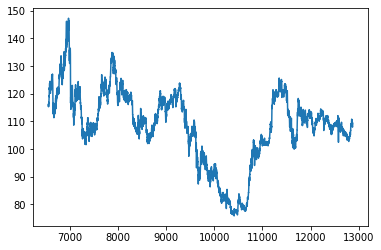

In [5]:
plt.plot(data['Close'])

In [6]:
warnings.filterwarnings('ignore') # 実行上問題ない注意は非表示にする

In [7]:
# pandasのDataFrameのままでは、扱いにくい+実行速度が遅いので、numpyに変換して処理します
data2 = np.array(data)

# 5日移動平均線を追加します
data2 = np.c_[data2, np.zeros((len(data2),1))] # 列の追加
ave_day = 5
for i in range(ave_day, len(data2)):
    tmp =data2[i-ave_day+1:i+1,4].astype(np.float) # pythonは0番目からindexが始まります
    data2[i,5] = np.mean(tmp)

# 25日移動平均線を追加します
data2 = np.c_[data2, np.zeros((len(data2),1))]
ave_day = 25
for i in range(ave_day, len(data2)):
    tmp =data2[i-ave_day+1:i+1,4].astype(np.float)
    data2[i,6] = np.mean(tmp)

# 75日移動平均線を追加します
data2 = np.c_[data2, np.zeros((len(data2),1))] # 列の追加
ave_day = 75
for i in range(ave_day, len(data2)):
    tmp =data2[i-ave_day+1:i+1,4].astype(np.float)
    data2[i,7] = np.mean(tmp)
    
# 200日移動平均線を追加します
data2 = np.c_[data2, np.zeros((len(data2),1))] # 列の追加
ave_day = 200
for i in range(ave_day, len(data2)):
    tmp =data2[i-ave_day+1:i+1,4].astype(np.float)
    data2[i,8] = np.mean(tmp)

# 一目均衡表を追加します (9,26,52) 
para1 =9
para2 = 26
para3 = 52

# 転換線 = （過去(para1)日間の高値 + 安値） ÷ 2
data2 = np.c_[data2, np.zeros((len(data2),1))] # 列の追加
for i in range(para1, len(data2)):
    tmp_high =data2[i-para1+1:i+1,2].astype(np.float)
    tmp_low =data2[i-para1+1:i+1,3].astype(np.float)
    data2[i,9] = (np.max(tmp_high) + np.min(tmp_low)) / 2 
    
# 基準線 = （過去(para2)日間の高値 + 安値） ÷ 2
data2 = np.c_[data2, np.zeros((len(data2),1))]
for i in range(para2, len(data2)):
    tmp_high =data2[i-para2+1:i+1,2].astype(np.float)
    tmp_low =data2[i-para2+1:i+1,3].astype(np.float)
    data2[i,10] = (np.max(tmp_high) + np.min(tmp_low)) / 2 

# 先行スパン1 = ｛ （転換値+基準値） ÷ 2 ｝を(para2)日先にずらしたもの
data2 = np.c_[data2, np.zeros((len(data2),1))]
for i in range(0, len(data2)-para2):
    tmp =(data2[i,9] + data2[i,10]) / 2 
    data2[i+para2,11] = tmp


# 先行スパン2 = ｛ （過去(para3)日間の高値+安値） ÷ 2 ｝を(para2)日先にずらしたもの
data2 = np.c_[data2, np.zeros((len(data2),1))]
for i in range(para3, len(data2)-para2):
    tmp_high =data2[i-para3+1:i+1,2].astype(np.float)
    tmp_low =data2[i-para3+1:i+1,3].astype(np.float)
    data2[i+para2,12] = (np.max(tmp_high) + np.min(tmp_low)) / 2 

# 25日ボリンジャーバンド（±1, 2シグマ）を追加します
parab = 25
data2 = np.c_[data2, np.zeros((len(data2),4))] # 列の追加
for i in range(parab, len(data2)):
    tmp = data2[i-parab+1:i+1,4].astype(np.float)
    data2[i,13] = np.mean(tmp) + 1.0* np.std(tmp) 
    data2[i,14] = np.mean(tmp) - 1.0* np.std(tmp) 
    data2[i,15] = np.mean(tmp) + 2.0* np.std(tmp) 
    data2[i,16] = np.mean(tmp) - 2.0* np.std(tmp) 


In [8]:
data2

array([['1997-01-02', 115.85, 116.2, ..., 0.0, 0.0, 0.0],
       ['1997-01-03', 115.65, 116.7, ..., 0.0, 0.0, 0.0],
       ['1997-01-06', 116.75, 116.98, ..., 0.0, 0.0, 0.0],
       ...,
       ['2021-04-29', 108.6, 109.222, ..., 108.31449962849005,
        110.96638074301988, 107.43053925698011],
       ['2021-04-30', 108.938, 109.342, ..., 108.30466399900833,
        110.94261200198336, 107.42534799801665],
       ['2021-04-30', 108.938, 109.342, ..., 108.29281073517105,
        110.90301852965791, 107.42274147034209]], dtype=object)

In [9]:
pd.DataFrame(data2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1997-01-02,115.85,116.2,115.28,115.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1997-01-03,115.65,116.7,115.35,116.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1997-01-06,116.75,116.98,115.38,115.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1997-01-07,115.74,116.02,114.8,115.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1997-01-08,115.22,116.0,114.9,115.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6309,2021-04-27,108.094,108.775,108.093,108.722,108.1478,109.21342,107.079967,105.783462,108.2235,109.2195,107.9955,106.3445,110.09223,108.33461,110.97104,107.4558
6310,2021-04-28,108.709,109.076,108.562,108.603,108.2544,109.20746,107.143073,105.790212,108.2785,109.2195,107.99975,106.3445,110.089877,108.325043,110.972294,107.442626
6311,2021-04-29,108.6,109.222,108.437,108.939,108.4502,109.19846,107.211273,105.800938,108.3515,109.2195,108.01225,106.3445,110.08242,108.3145,110.966381,107.430539
6312,2021-04-30,108.938,109.342,108.715,109.293,108.7304,109.18398,107.283313,105.811678,108.4115,109.2195,108.01225,106.3445,110.063296,108.304664,110.942612,107.425348


In [10]:
# 説明変数となる行列Xを作成します
day_ago = 25 # 何日前までのデータを使用するのかを設定
num_sihyou = 1 + 4 + 4 +4 # 終値1本、MVave4本、itimoku4本、ボリンジャー4本

X = np.zeros((len(data2), day_ago*num_sihyou)) 

for s in range(0, num_sihyou): # 日にちごとに横向きに並べる
    for i in range(0, day_ago):
        X[i:len(data2),day_ago*s+i] = data2[0:len(data2)-i,s+4]

# 被説明変数となる Y = pre_day後の終値-当日終値 を作成します
Y = np.zeros(len(data2))

# 何日後を値段の差を予測するのか決めます
pre_day = 1
Y[0:len(Y)-pre_day] = X[pre_day:len(X),0] - X[0:len(X)-pre_day,0]

# 【重要】X, Yを正規化します
original_X = np.copy(X) # コピーするときは、そのままイコールではダメ
tmp_mean = np.zeros(len(X))

for i in range(day_ago,len(X)):
    tmp_mean[i] = np.mean(original_X[i-day_ago+1:i+1,0]) # 25日分の平均値
    for j in range(0, X.shape[1]): 
        X[i,j] = (X[i,j] - tmp_mean[i]) # Xを正規化
    Y[i] =  Y[i] # X同士の引き算しているので、Yはそのまま

In [11]:
X=X[200:len(X)-pre_day,]
Y=Y[200:len(Y)-pre_day]

In [12]:
len(X)

6113

In [13]:
len(Y)

6113

In [14]:
# XとYを学習データとテストデータに分ける
#X_train = X[200:5713,:] 
#Y_train = Y[200:5713] 

#X_test = X[5713:len(X)-pre_day,:] 
#Y_test = Y[5713:len(Y)-pre_day]





In [15]:
#X_train

In [16]:
from sklearn.linear_model import Ridge 
#from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y,train_size=0.8,shuffle=False)
ridge = Ridge().fit(X_train, Y_train)
#ridge = linear_model.LinearRegression().fit(X_train,Y_train)


In [18]:
print("intercept:{}".format(ridge.intercept_))
print("Train score:{}".format(ridge.score(X_train,Y_train)))
print("Test score:{}".format(ridge.score(X_test,Y_test)))

intercept:0.010623393700131274
Train score:0.06515764261487333
Test score:-0.03975120937176313


予測日数：1223、正解日数：665、正解率：54.37448896156991


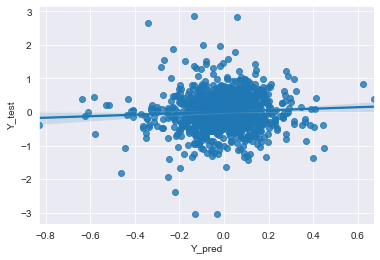

In [19]:
# 2017年のデータで予想し、グラフで予測具合を見る

Y_pred = ridge.predict(X_test) # 予測する

result = pd.DataFrame(Y_pred) # 予測
result.columns = ['Y_pred']
result['Y_test'] = Y_test


sns.set_style('darkgrid') 
sns.regplot(x='Y_pred', y='Y_test', data=result) #plotする


# 正答率を計算
success_num = 0
for i in range(len(Y_pred)):
    if Y_pred[i] * Y_test[i] >=0:
        success_num+=1

print("予測日数："+ str(len(Y_pred))+"、正解日数："+str(success_num)+"、正解率："+str(success_num/len(Y_pred)*100))


利益合計：53.091


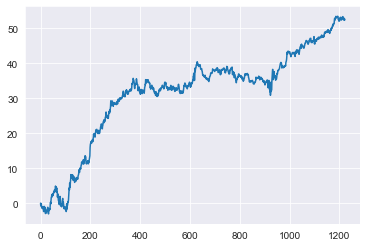

In [20]:
sum_2017 = 0

for i in range(0,len(Y_test)): # len()で要素数を取得しています
    if Y_pred[i] >= 0:
        sum_2017 += Y_test[i]
    else:
        sum_2017 -= Y_test[i]

print("利益合計：%1.3lf" %sum_2017) 


# 予測結果の総和グラフを描くーーーーーーーーー
total_return = np.zeros(len(Y_test))

if Y_pred[i] >=0: # 2017年の初日を格納
    total_return[0] = Y_test[i]
else:
    total_return[0] = -Y_test[i]

for i in range(1, len(result)): # 2017年の2日以降を格納
    if Y_pred[i] >=0:
        total_return[i] = total_return[i-1] + Y_test[i]
    else:
        total_return[i] = total_return[i-1] - Y_test[i]

plt.plot(total_return)

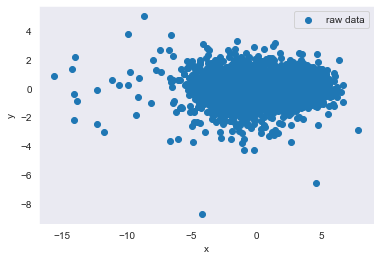

In [23]:
plt.scatter(X[:,0], Y, label='raw data')
#plt.plot(X, Y, label='正解データ')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()